# Online to Offline: where is the best place to settle?

## Intro

This project aims to assist online businesses to go offline by helping them choosing the best place to open their physical location close to their customers.

### How does the model work?

1. Gather the geographical information of users (coordinates/addresses)
2. Define a unique location for each user (mean)
3. Build clusters to regroup users
4. Analyze the clusters’ regions
5. Find the best spot to rent / buy a place (via Zap Imóveis)

### For whom it can be useful?


Any business that has its customer locations, such as:

1. Restaurants with Delivery Customer data
2. Companies that want to move their office
3. E-commerce shops that wish to implement storage closer to their clients

## 1. Data: importing and cleaning

We worked with some data from Appito - an app to organize soccer games. Before the pandemic, they had around 140.000 active users and organizes around 4.000 games per week. To develop their users’ experience, Appito has opened in 2020 an Arena in São Paulo to host games.

Now, they want to find the best spot to build a new Arena, so we used their data to understand their users' locations and to group them geographically. Business parameters were also considered to define the best place to implement the Arena.

In [1]:
# importing the libraries that we'll use further on:

import pandas as pd
import numpy as np
from datetime import datetime
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from k_means_constrained import KMeansConstrained
from haversine import haversine
import zapimoveis_scraper as zap

###  Users' data

Content: all users registered in the app and their cellphones' coordinates

In [2]:
# reading and instantiating:
users = pd.read_csv('gs://appito_arenas_data/users.csv', delimiter=";")
users

,ID,CreateDate,Latitude,Longitude,Real
0,0x39E34271C99315ED0556E3760DF7F73E,2016-04-01 23:40:27.620,NaN,NaN,1
1,0x876797655865FB39C20B034E84C7789D,2018-07-31 18:04:21.637,NaN,NaN,1
2,0x343B61BC42DC02472441DA0DC7D3D970,2019-11-12 18:45:15.287,"-22,8356014","-43,0567894",1
3,0xFC226669F201F3257FF3EBCAAFB2F44A,2018-09-22 16:06:04.640,"-23,5786916666667","-46,5391683333333",1
4,0xAAB91837B368993AD86F8931A947D0BD,2018-11-28 22:37:33.613,NaN,NaN,1
...,...,...,...,...,...
1354086,0x40F0E530B2623EFEF128928998EE0897,2019-03-02 15:22:38.637,"-23,5498772","-46,6361756",1
1354087,0xA01FE9072DB9B3AD28D16949D8201434,2019-10-21 11:31:49.587,"-9,73629089146465","-35,825945049321",1
1354088,0x60333B88EB06DAF5277422E4D71CFE6A,2018-01-16 19:32:17.237,"-23,68728739","-23,68728739",1
1354089,0x7E539D36B97AB6EA398CEB23CDFF5047,2019-10-30 19:39:13.627,"-23,5498772","-46,6361756",1


The user's table has more than 1.3M rows (one for each user) and 5 columns. There are some users with 'NaN' values at 
'Latitude' and 'Longitude', and a 'Real' binary column that identifies real users (1, for real; 0, else):

In [3]:
# we'll be working with coordinates so we'll drop the users with 'NaN' values:
users_clean = users.dropna(axis=0, how='any')

# we'll also filter the real users and keep only observations from 2018 forward:
users_clean = users_clean[users_clean['Real'] == 1]
users_clean['CreateDate'] = pd.to_datetime(users_clean['CreateDate'], format='%Y-%m-%d %H:%M:%S')
users_clean = users_clean[users_clean['CreateDate'].dt.year >= 2018]

# since 'CreateDate' and 'Real' will have no use for us further on, we'll drop them:
users_clean.drop(columns=['CreateDate', 'Real'], inplace=True)

# we'll also edit the column's names to snake_case convention:
users_clean.rename(columns={'ID' : 'user_id', 'Latitude' : 'latitude', 'Longitude' : 'longitude'}, inplace=True)

# we'll create a new column to keep track of the origin of the observations ('C' for cellphone):
users_clean['origin'] = 'C'

# we create a 'coordinates' column that adds latitude and longitude in the same string (rounded to 6 decimals each):
users_clean['latitude'] = users_clean['latitude'].str.replace(',', '.').astype(float)
users_clean['longitude'] = users_clean['longitude'].str.replace(',', '.').astype(float)
users_clean['coordinates'] = round(users_clean['latitude'], 6).astype(str) + ',' + round(users_clean['longitude'], 6).astype(str)
users_clean.reset_index(drop=True, inplace=True)

#this is how the new dataframe looks like:
users_clean

,user_id,latitude,longitude,origin,coordinates
0,0x343B61BC42DC02472441DA0DC7D3D970,-22.835601,-43.056789,C,"-22.835601,-43.056789"
1,0xFC226669F201F3257FF3EBCAAFB2F44A,-23.578692,-46.539168,C,"-23.578692,-46.539168"
2,0xB1435E9ECB3F30691614631B05533B7A,-18.789280,-44.456657,C,"-18.78928,-44.456657"
3,0x1AD3568DA71ABD90C1453C4007239FA7,-23.549877,-46.636176,C,"-23.549877,-46.636176"
4,0x143B1358AEE9CB4AA6B1A0268D47AC5D,-23.572150,-46.643726,C,"-23.57215,-46.643726"
...,...,...,...,...,...
577795,0xE4DDBF4994B2ADF552357AF3334A4570,-23.549877,-46.636176,C,"-23.549877,-46.636176"
577796,0x40F0E530B2623EFEF128928998EE0897,-23.549877,-46.636176,C,"-23.549877,-46.636176"
577797,0xA01FE9072DB9B3AD28D16949D8201434,-9.736291,-35.825945,C,"-9.736291,-35.825945"
577798,0x60333B88EB06DAF5277422E4D71CFE6A,-23.687287,-23.687287,C,"-23.687287,-23.687287"


With this first step of cleaning, we dropped more than half the users from the original table.


Before moving on to the next tables, we have to check the coordinates values:

In [4]:
# checking the most frequent values in 'coordinates' column:
users_clean['coordinates'].value_counts().head(30)

-23.549877,-46.636176    231992
-23.549877,-46.636177      1674
0.0,0.0                     117
-23.549868,-46.636177        34
37.633992,-122.433807        24
-23.570354,-46.661236         9
-10.94142,-51.75133           8
-12.643406,-54.386341         6
-23.546118,-46.650215         6
-23.561954,-46.628643         6
-14.26104,-41.581254          6
-23.55052,-46.633308          5
-23.549866,-46.636177         5
-9.157433,38.760706           5
31.24916,121.487898           5
-15.78,-47.93                 4
-23.585943,-46.730896         4
-23.539021,-46.641689         4
-3.732718,-38.526997          4
-23.594471,-46.691425         3
-23.631601,-46.5928           3
-13.0,-54.0                   3
-6.851673,-39.533068          3
-23.565566,-46.334012         3
-23.529757,-46.736828         3
-23.174688,-50.637791         3
-25.400455,-49.246895         3
-23.966148,-46.38916          2
-12.076157,-45.756214         2
-22.654265,-43.656017         2
Name: coordinates, dtype: int64

There are 231.992 rows with the same coordinate, and also several others repeated values. We checked them in Google Maps and concluded that they're default coordinate's values for users without location data, so we'll drop the rows with the top 27 coordinates (3 or more repetitions):

In [5]:
# listing the top 27 repeated coordinates and applying them to a variable:

bad_coordinates_C = users_clean['coordinates'].value_counts().index[:27]
bad_coordinates_C

Index(['-23.549877,-46.636176', '-23.549877,-46.636177', '0.0,0.0',
       '-23.549868,-46.636177', '37.633992,-122.433807',
       '-23.570354,-46.661236', '-10.94142,-51.75133', '-12.643406,-54.386341',
       '-23.546118,-46.650215', '-23.561954,-46.628643',
       '-14.26104,-41.581254', '-23.55052,-46.633308', '-23.549866,-46.636177',
       '-9.157433,38.760706', '31.24916,121.487898', '-15.78,-47.93',
       '-23.585943,-46.730896', '-23.539021,-46.641689',
       '-3.732718,-38.526997', '-23.594471,-46.691425', '-23.631601,-46.5928',
       '-13.0,-54.0', '-6.851673,-39.533068', '-23.565566,-46.334012',
       '-23.529757,-46.736828', '-23.174688,-50.637791',
       '-25.400455,-49.246895'],
      dtype='object')

In [6]:
# removing all of the rows with any of the listed coordinates:

for coords in bad_coordinates_C:
    users_clean = users_clean[users_clean['coordinates'] != coords]
users_clean.reset_index(drop=True, inplace=True)
users_clean

,user_id,latitude,longitude,origin,coordinates
0,0x343B61BC42DC02472441DA0DC7D3D970,-22.835601,-43.056789,C,"-22.835601,-43.056789"
1,0xFC226669F201F3257FF3EBCAAFB2F44A,-23.578692,-46.539168,C,"-23.578692,-46.539168"
2,0xB1435E9ECB3F30691614631B05533B7A,-18.789280,-44.456657,C,"-18.78928,-44.456657"
3,0x143B1358AEE9CB4AA6B1A0268D47AC5D,-23.572150,-46.643726,C,"-23.57215,-46.643726"
4,0x4DD9B7102F3920279CF3EC6C39B6B4B7,-3.751369,-38.582589,C,"-3.751369,-38.582589"
...,...,...,...,...,...
343853,0x00AB4BF1142F2672268B6F75A7FBA1B2,-7.020396,-37.945674,C,"-7.020396,-37.945674"
343854,0xB142412B2480C5E7266EF20871429086,-18.871551,-48.294196,C,"-18.871551,-48.294196"
343855,0x73EE99AE5C8BBABFB2A6CB756B9BCF5A,-15.798791,-47.908302,C,"-15.798791,-47.908302"
343856,0xA01FE9072DB9B3AD28D16949D8201434,-9.736291,-35.825945,C,"-9.736291,-35.825945"


After this cleaning step we remained with 343.858 real users with real coordinates.


Now it's time to import and work on the matches' table:

###  Matches' data

Content: all matches played and registered in the app, it's coordinates and some other features

In [7]:
matches = pd.read_csv('gs://appito_arenas_data/matches.csv', delimiter=";")
matches

,ID,Data,Horário início,Horário final,Confirmados,NoShow,Cancelada,Latitude,Longitude,Mensal
0,0xF14E6CEAF3C95EF914D1D599BEF9E205,2016-01-09,20:30,22:00,1,0,0,"-20,1858248105916","-40,256538951223",0
1,0x48E1E88E90F576AE4ED5D4A732231628,2016-02-09,14:15,15:00,2,0,0,"-22,8744662","-43,2945181",0
2,0xE951ABD7BD97F88334DC27C78CD6B072,2016-04-07,00:00,00:45,1,0,1,"-22,704942","-43,278179",0
3,0xBF5FF5F9CB7A345BBA7F368B907948DA,2016-04-29,21:00,23:00,1,0,1,"-23,516112","-46,684527",0
4,0x4FAB58639681946F58AF2C3DFB1BDFFE,2016-04-30,07:45,09:15,1,0,0,"51,5235214233398","-0,0752077028155327",0
...,...,...,...,...,...,...,...,...,...,...
1358675,0xBCD4471A3093CA9F2AF627506A8FC562,2021-08-04,23:55,00:40,1,0,0,"-22,9882125854492","-47,1453094482422",1
1358676,0x5E44424823FD5959041FA75257D6F98D,2021-08-04,23:55,00:40,8,0,0,"-30,0530605316162","-51,170711517334",1
1358677,0xFB47E75FC0B0D1718D96C07C7BB477C8,2021-08-04,23:55,00:55,4,0,0,"-23,9684856","-46,3452769",0
1358678,0x36C25F1855389E41519FD8149748E43D,2021-08-04,23:55,00:55,4,0,0,"-23,9684856","-46,3452769",0


In [8]:
# we'll work on a copy of matches, so we can refer back to unnaltered one if we have to:
matches_clean = matches.copy()

# we'll do the same process as we did on user's table:
matches_clean['Data'] = pd.to_datetime(matches_clean['Data'])
matches_clean = matches_clean[matches_clean['Data'].dt.year >= 2018]
matches_clean = matches_clean.drop(columns=['Data', 'Horário início', 'Horário final', 'Confirmados', 'NoShow', 'Cancelada', 'Mensal'])
matches_clean = matches_clean.rename(columns={'ID': 'match_id', 'Latitude' : 'latitude' , 'Longitude' : 'longitude'})
matches_clean['latitude'] = matches_clean['latitude'].str.replace(',', '.').astype(float)
matches_clean['longitude'] = matches_clean['longitude'].str.replace(',', '.').astype(float)
matches_clean['coordinates'] = round(matches_clean['latitude'], 6).astype(str) + ',' + round(matches_clean['longitude'], 6).astype(str)
matches_clean['origin'] = 'M'
matches_clean.reset_index(inplace=True, drop=True)
matches_clean

,match_id,latitude,longitude,coordinates,origin
0,0xDF996E0B4F3A53D91FF0FD68C2EE82B8,-26.897156,-48.648237,"-26.897156,-48.648237",M
1,0x9F59562E971B8E44134B097E7067AE99,-12.895207,-38.429416,"-12.895207,-38.429416",M
2,0xAD644BBDC4F60AD8C3534162C11DCE14,-8.076290,-34.912854,"-8.07629,-34.912854",M
3,0x703F8F747D5DD7FC693AD2B7480AD232,-22.572630,-44.968754,"-22.57263,-44.968754",M
4,0x6CFB783F638B4E85A47EAC304A8C60A0,-23.210346,-46.785915,"-23.210346,-46.785915",M
...,...,...,...,...,...
1263069,0xBCD4471A3093CA9F2AF627506A8FC562,-22.988213,-47.145309,"-22.988213,-47.145309",M
1263070,0x5E44424823FD5959041FA75257D6F98D,-30.053061,-51.170712,"-30.053061,-51.170712",M
1263071,0xFB47E75FC0B0D1718D96C07C7BB477C8,-23.968486,-46.345277,"-23.968486,-46.345277",M
1263072,0x36C25F1855389E41519FD8149748E43D,-23.968486,-46.345277,"-23.968486,-46.345277",M


In [9]:
# listing the most frequent coordinates in matche's table:
matches_clean['coordinates'].value_counts().head(30)

-28.738687,-49.475783    22205
-23.554045,-46.632083    13561
-23.719621,-45.458472    11016
-23.549853,-46.63618      8663
-23.549877,-46.636176     6801
-23.53902,-46.641688      4126
-23.55524,-46.64216       3611
-23.523521,-46.743413     3107
-23.570354,-46.661236     2348
-23.536776,-46.637947     2081
-21.778973,-41.313824     1555
-23.560654,-46.649337     1370
-23.5199,-46.6784         1294
-23.560619,-46.616135     1205
-23.455315,-46.539593     1139
38.789715,-9.111382       1000
-23.482828,-46.723293      982
-27.592302,-48.51804       953
-23.552704,-46.596797      926
-23.5218,-46.6789          912
-22.92869,-43.174191       897
-30.053061,-51.170712      893
-23.599699,-46.747276      872
-23.624466,-46.695164      830
-23.706528,-46.575325      827
-23.52331,-46.617077       816
-23.646875,-46.590062      816
-23.43885,-46.71442        782
-23.71689,-46.777241       747
-23.618916,-46.580131      718
Name: coordinates, dtype: int64

Checking the coordinates on Google Maps, we can conclude that:

- The 4th and 5th are the same default coordinates from users, so we'll drop them;
- There are some places in this list that seems a bit odd (specially the 1st one), but we can't discard them for now;

In [10]:
# atributing the fake coordinates to a new variable:
bad_coordinates_M = [matches_clean['coordinates'].value_counts().index[3],
                    matches_clean['coordinates'].value_counts().index[4]]
bad_coordinates_M

['-23.549853,-46.63618', '-23.549877,-46.636176']

In [11]:
# removing the rows that contains either of them:
for coords in bad_coordinates_M:
    matches_clean = matches_clean[matches_clean['coordinates'] != coords]
matches_clean.reset_index(drop=True, inplace=True)
matches_clean

,match_id,latitude,longitude,coordinates,origin
0,0xDF996E0B4F3A53D91FF0FD68C2EE82B8,-26.897156,-48.648237,"-26.897156,-48.648237",M
1,0x9F59562E971B8E44134B097E7067AE99,-12.895207,-38.429416,"-12.895207,-38.429416",M
2,0xAD644BBDC4F60AD8C3534162C11DCE14,-8.076290,-34.912854,"-8.07629,-34.912854",M
3,0x703F8F747D5DD7FC693AD2B7480AD232,-22.572630,-44.968754,"-22.57263,-44.968754",M
4,0x6CFB783F638B4E85A47EAC304A8C60A0,-23.210346,-46.785915,"-23.210346,-46.785915",M
...,...,...,...,...,...
1247605,0xBCD4471A3093CA9F2AF627506A8FC562,-22.988213,-47.145309,"-22.988213,-47.145309",M
1247606,0x5E44424823FD5959041FA75257D6F98D,-30.053061,-51.170712,"-30.053061,-51.170712",M
1247607,0xFB47E75FC0B0D1718D96C07C7BB477C8,-23.968486,-46.345277,"-23.968486,-46.345277",M
1247608,0x36C25F1855389E41519FD8149748E43D,-23.968486,-46.345277,"-23.968486,-46.345277",M


After this step, we remain with 1.247.610 matches with clean and plausible coordinates.

### Matches' players data

Content: all users registered to play in every match

In [12]:
matchesplayers = pd.read_csv('gs://appito_arenas_data/matchesplayers.csv', delimiter=";")
matchesplayers

,UserID,MatchID,State
0,0xD80AF879D3D52EBE20CCF0F9EDCF024F,0x39E34271C99315ED0556E3760DF7F73E,I
1,0xD0F498522E9DC345FE23CE85E7BCD2A0,0x39E34271C99315ED0556E3760DF7F73E,I
2,0x10741DF6AF9215A235886646F749BA10,0x39E34271C99315ED0556E3760DF7F73E,I
3,0xE4B28EA5899FA4678C8DA3485FA46BF4,0x39E34271C99315ED0556E3760DF7F73E,I
4,0x7B844253123FF42F54580466138978DD,0x39E34271C99315ED0556E3760DF7F73E,I
...,...,...,...
8101932,0x6D0A3227DDB272E9E12D917ECC3E78E9,0xBFA3F70A772F91BDEA8211E794D2BCA9,I
8101933,0x4153C8B8384EAA0AA1111511A63AF19B,0xBFA3F70A772F91BDEA8211E794D2BCA9,X
8101934,0x8E3F328653A15EB99B7F00FDDDC7201A,0xBB58059F19BD592EF18B6B361AF7509F,I
8101935,0xD63EFD52EAEADA9ED75827ED021191E0,0xBB58059F19BD592EF18B6B361AF7509F,X


In [13]:
# we'll edit the way as the previous ones and keep only the rows with state 'X',
# a confirmation that the player's presence in the match:

matchesplayers_clean = matchesplayers.copy()
matchesplayers_clean.columns = ['user_id', 'match_id', 'state']
matchesplayers_clean = matchesplayers_clean[matchesplayers_clean['state'] == 'X']
matchesplayers_clean.drop(columns=['state'], inplace=True)
matchesplayers_clean.reset_index(inplace=True, drop=True)
matchesplayers_clean

,user_id,match_id
0,0xA1527DE2F9139E2717BB4C8C8885BAB9,0x39E34271C99315ED0556E3760DF7F73E
1,0xE7CBE96E56B5D6BB6EAEDBA253F73269,0x72AAFF157FC8C1072728EBFF9461F9E2
2,0x3E4848261840E554968DF3BA4DFD22F7,0x96B3026C360FB1CCC6D7CD874F84BAAE
3,0x9FF2E13544133E6D83E00C286D94B8B0,0x6355E6E3630B73330C91860A02F1479B
4,0x7BAADD89E9C6F5ED41E48439337BF011,0x6355E6E3630B73330C91860A02F1479B
...,...,...
2860588,0x34B452D3BBC4220EE4C917154F713A36,0x872BA484625B5F22FF408DB5DEE0CA64
2860589,0x879B8FFE2B9C0E78F6E41427C83D9AA1,0x38D76C49B0497FFB628E1E2620D9AF49
2860590,0x4153C8B8384EAA0AA1111511A63AF19B,0xBFA3F70A772F91BDEA8211E794D2BCA9
2860591,0xD63EFD52EAEADA9ED75827ED021191E0,0xBB58059F19BD592EF18B6B361AF7509F


This process leaves us with 2.860.593 rows

## 2. Prepping the model's input

Now that we've imported and cleaned all of the raw data, we can begin the process of merging and cleaning.

### Merging


First, we merge the 'users_clean' with the matchesplayers on 'user_id', and keep only the users that actually played at least once:

In [14]:
real_players = users_clean.merge(matchesplayers_clean, how='inner', on='user_id')
real_players

,user_id,latitude,longitude,origin,coordinates,match_id
0,0xFC226669F201F3257FF3EBCAAFB2F44A,-23.578692,-46.539168,C,"-23.578692,-46.539168",0x84ED0D0835B5EB2BCF4C44164B4860F2
1,0xFC226669F201F3257FF3EBCAAFB2F44A,-23.578692,-46.539168,C,"-23.578692,-46.539168",0x1FC69A59A8F150DFDD3AA9CADF071A7C
2,0xFC226669F201F3257FF3EBCAAFB2F44A,-23.578692,-46.539168,C,"-23.578692,-46.539168",0xD10CB4A8B9DDD907957EABE73ADA0348
3,0xFC226669F201F3257FF3EBCAAFB2F44A,-23.578692,-46.539168,C,"-23.578692,-46.539168",0xC34FF14D48C9315983BC149379E9C35B
4,0xFC226669F201F3257FF3EBCAAFB2F44A,-23.578692,-46.539168,C,"-23.578692,-46.539168",0xDD020322E716CE78F6EA820A68897CA3
...,...,...,...,...,...,...
1010022,0x2D5F8D9A42371F5906997E21FA3F4F4B,-25.373737,-49.220181,C,"-25.373737,-49.220181",0x1DE80C0FBD21455DF5C46C449792C780
1010023,0x6273A031B33D785855EB21AB67DE787E,-23.695803,-46.648800,C,"-23.695803,-46.6488",0x7A4C6D308D2E05E1931BF0AA6357B591
1010024,0x00AB4BF1142F2672268B6F75A7FBA1B2,-7.020396,-37.945674,C,"-7.020396,-37.945674",0x55A438C387DD6FE25476F345583D0FA9
1010025,0x00AB4BF1142F2672268B6F75A7FBA1B2,-7.020396,-37.945674,C,"-7.020396,-37.945674",0x1D13E6251E1ADDFFC20B1B4312C69219


Now we have a 'real_players' dataframe, with more than 1M observations. And then we'll merge it with the 'matches_clean' dataframe on 'match_id':

In [15]:
# in order to do this merge we need to drop common columns, so they don't get duplicated:
matches_loc_per_user = pd.merge(real_players.drop(columns=['latitude', 'longitude', 'coordinates', 'origin']), 
                                matches_clean, on = 'match_id', how='inner')
matches_loc_per_user

,user_id,match_id,latitude,longitude,coordinates,origin
0,0xFC226669F201F3257FF3EBCAAFB2F44A,0x84ED0D0835B5EB2BCF4C44164B4860F2,-23.519900,-46.678400,"-23.5199,-46.6784",M
1,0x0A604B6D39318B8F315ECEBF181D082D,0x84ED0D0835B5EB2BCF4C44164B4860F2,-23.519900,-46.678400,"-23.5199,-46.6784",M
2,0x0B3EBEBBD233AC3FC643739B624406AC,0x84ED0D0835B5EB2BCF4C44164B4860F2,-23.519900,-46.678400,"-23.5199,-46.6784",M
3,0x7376EBA27977B4B28EF459753ED638E9,0x84ED0D0835B5EB2BCF4C44164B4860F2,-23.519900,-46.678400,"-23.5199,-46.6784",M
4,0xC79695028643EC3E9E9E2F6FA50BE1FF,0x84ED0D0835B5EB2BCF4C44164B4860F2,-23.519900,-46.678400,"-23.5199,-46.6784",M
...,...,...,...,...,...,...
1006488,0x7767E8038D3479C7DB219B37D5C01800,0x64C8AA4BA70CB05219977EC61519AA28,-30.047516,-51.051849,"-30.047516,-51.051849",M
1006489,0x7767E8038D3479C7DB219B37D5C01800,0x8559301BDE246A84D9F583B6438AF767,-30.047516,-51.051849,"-30.047516,-51.051849",M
1006490,0x08C66555F741008E4CAAFB78F768FE02,0xFC1686E6BC5A41DE79FCAB96187533C9,-23.533795,-46.588054,"-23.533795,-46.588054",M
1006491,0x53FA5961295173CFC994E4D45B8E6014,0xF3C690346CBB0418ED8872DBE115C675,-24.556862,-54.058579,"-24.556862,-54.058579",M


In [16]:
# after the merge, we drop the 'match_id' column because it's not useful anymore:
matches_loc_per_user.drop(columns=['match_id'], inplace=True)
matches_loc_per_user

,user_id,latitude,longitude,coordinates,origin
0,0xFC226669F201F3257FF3EBCAAFB2F44A,-23.519900,-46.678400,"-23.5199,-46.6784",M
1,0x0A604B6D39318B8F315ECEBF181D082D,-23.519900,-46.678400,"-23.5199,-46.6784",M
2,0x0B3EBEBBD233AC3FC643739B624406AC,-23.519900,-46.678400,"-23.5199,-46.6784",M
3,0x7376EBA27977B4B28EF459753ED638E9,-23.519900,-46.678400,"-23.5199,-46.6784",M
4,0xC79695028643EC3E9E9E2F6FA50BE1FF,-23.519900,-46.678400,"-23.5199,-46.6784",M
...,...,...,...,...,...
1006488,0x7767E8038D3479C7DB219B37D5C01800,-30.047516,-51.051849,"-30.047516,-51.051849",M
1006489,0x7767E8038D3479C7DB219B37D5C01800,-30.047516,-51.051849,"-30.047516,-51.051849",M
1006490,0x08C66555F741008E4CAAFB78F768FE02,-23.533795,-46.588054,"-23.533795,-46.588054",M
1006491,0x53FA5961295173CFC994E4D45B8E6014,-24.556862,-54.058579,"-24.556862,-54.058579",M


The output is a dataframe with the location of each match a user played. Now we want to concatenate this with the 'users_clean' dataframe, so we can have all of the interactions of every user - cellphone (C) and matches (M) coordinates - in a single dataframe:

In [17]:
# in order to keep only users with registers in both origins, C and M, we need to drop the duplicates for the concat:
final_df = pd.concat([real_players.drop(columns='match_id').drop_duplicates(), matches_loc_per_user.drop_duplicates()])

# then we sort the dataframe by 'user_id', in order to see all the observations together for each user:
final_df = final_df.sort_values('user_id')
final_df

,user_id,latitude,longitude,origin,coordinates
72403,0x000034F383E0A1F82F6F251B17B7611A,-8.213413,-8.213413,C,"-8.213413,-8.213413"
203536,0x000034F383E0A1F82F6F251B17B7611A,-8.208950,-34.958598,M,"-8.20895,-34.958598"
229825,0x000077FF355F239607A3327FD90C82D2,-29.925139,-51.163535,C,"-29.925139,-51.163535"
49333,0x000077FF355F239607A3327FD90C82D2,-29.930372,-51.162725,M,"-29.930372,-51.162725"
424183,0x0000A09DE7C5FBBB72EE84E5A44E6E5C,-25.214658,-49.347787,M,"-25.214658,-49.347787"
...,...,...,...,...,...
142778,0xFFFF595F516EF7024A74D8594B7CC72E,-19.918043,-43.945335,M,"-19.918043,-43.945335"
906637,0xFFFFA4BFD55F033F1AE42997539F51D1,-23.079803,-47.206807,C,"-23.079803,-47.206808"
33816,0xFFFFA4BFD55F033F1AE42997539F51D1,-23.096441,-47.230640,M,"-23.096441,-47.23064"
416242,0xFFFFFC97A8A9F1EDEC63F807F12F538B,-23.538271,-46.400885,M,"-23.538271,-46.400885"


That's the merged dataframe that we wanted to build. It has 322.759 rows.


It has 129.208 different users:

In [18]:
final_df['user_id'].nunique()

129208

### Selecting only brazilian data

Although the majority of the coordinates are from Brazil some are from other countries, and since Appito wants to build a new arena in Brazil, we need to discard foreign observations.

First, we searched for the coordinates of the 4 extremes of brazilian area (north, south, east and west), so we could keep only the rows inside this 'rectangle' area:

In [19]:
final_df = final_df[(final_df['latitude'] > -33.76) & (final_df['latitude'] < 5.26)]
final_df = final_df[(final_df['longitude'] > -74) & (final_df['longitude'] < -34.8)]
final_df

,user_id,latitude,longitude,origin,coordinates
203536,0x000034F383E0A1F82F6F251B17B7611A,-8.208950,-34.958598,M,"-8.20895,-34.958598"
229825,0x000077FF355F239607A3327FD90C82D2,-29.925139,-51.163535,C,"-29.925139,-51.163535"
49333,0x000077FF355F239607A3327FD90C82D2,-29.930372,-51.162725,M,"-29.930372,-51.162725"
424183,0x0000A09DE7C5FBBB72EE84E5A44E6E5C,-25.214658,-49.347787,M,"-25.214658,-49.347787"
565044,0x0000A09DE7C5FBBB72EE84E5A44E6E5C,-25.434135,-49.265799,C,"-25.434135,-49.265799"
...,...,...,...,...,...
142778,0xFFFF595F516EF7024A74D8594B7CC72E,-19.918043,-43.945335,M,"-19.918043,-43.945335"
906637,0xFFFFA4BFD55F033F1AE42997539F51D1,-23.079803,-47.206807,C,"-23.079803,-47.206808"
33816,0xFFFFA4BFD55F033F1AE42997539F51D1,-23.096441,-47.230640,M,"-23.096441,-47.23064"
416242,0xFFFFFC97A8A9F1EDEC63F807F12F538B,-23.538271,-46.400885,M,"-23.538271,-46.400885"


As you can see in the map bellow, the 'rectangle' approach was good, but not enough to get rid of all of the foreign data. The plot/map bellow shows a few points west that needs to be discarded. And also there are 2 strange 'islands' near the southern coast, that demands a closer look.

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

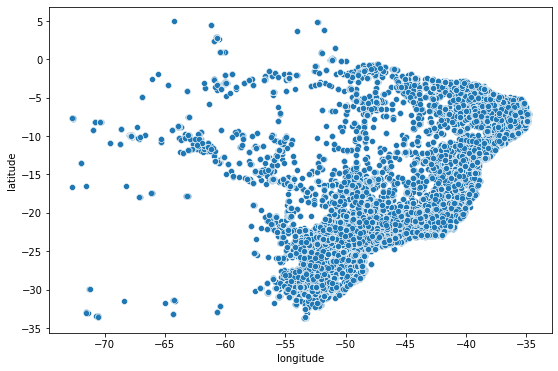

In [20]:
plt.figure(figsize=(9,6))
sns.scatterplot(x=final_df['longitude'], y=final_df['latitude'])

First we'll deal with the foreign data. We could use the 'geopy' library to check all the coordinates and return their country's names, but with almost 170.000 different values this would take more than 24 hours, so we need a faster approach.

Knowing that all of the foreign data are in the left side of the map, we can choose a longitude point that would contain all of the foreign coordinates to the left and still doesn't contain too much brazilian points:

In [21]:
# we figured that -53.4 is a nice longitude to 'draw' this limit:
sudamerica = final_df[final_df['longitude'] < -53.4][['user_id', 'coordinates']]
sudamerica.reset_index(drop=True, inplace=True)
sudamerica_uniques = sudamerica['coordinates'].unique()
sudamerica['coordinates'].nunique()

9539

This new section has only 9.521 different coordinates. This will reduce the 'geopy' process to 1 hour and 30 minutes.

In [22]:
# %%time

# import geopy
# from geopy.geocoders import Nominatim
# geolocator = Nominatim(user_agent='myGeocoder')

# list_loc = []
# for l in range(len(sudamerica_uniques)):
#     location = geolocator.reverse(sudamerica_uniques[l])
#     dict_location = location.raw['address']['country']
#     list_loc.append(dict_location)
#     print(l)

# new_locs = pd.DataFrame(list_loc)

# sudamerica_uniques = pd.DataFrame(sudamerica_uniques)
# outsiders = sudamerica_uniques.merge(new_locs, left_index=True, right_index=True)

# outsiders = outsiders[outsiders['0_y'] != 'Brasil']

In [23]:
# finally we have a dataframe with all the foreign coordinates and their respective countries:
outsiders = pd.read_csv('gs://appito_arenas_data/sudamerica.csv')
outsiders

,0_x,0_y
0,"3.643433,-54.028568",France
1,"3.643804,-54.028488",France
2,"-33.497773,-70.568182",Chile
3,"-24.975992,-54.920562",Paraguay
4,"-24.899808,-54.944365",Paraguay
...,...,...
181,"-24.064067,-54.307661",Paraguay
182,"-28.552277,-56.039833",Argentina
183,"-25.836378,-55.176982",Paraguay
184,"-25.874887,-55.627694",Paraguay


In [24]:
# we remove the rows from 'final_df' that contains any of the coordinates in 'outsiders':
for coords in outsiders['0_x']:
    final_df = final_df[final_df['coordinates'] != coords]
final_df

,user_id,latitude,longitude,origin,coordinates
203536,0x000034F383E0A1F82F6F251B17B7611A,-8.208950,-34.958598,M,"-8.20895,-34.958598"
229825,0x000077FF355F239607A3327FD90C82D2,-29.925139,-51.163535,C,"-29.925139,-51.163535"
49333,0x000077FF355F239607A3327FD90C82D2,-29.930372,-51.162725,M,"-29.930372,-51.162725"
424183,0x0000A09DE7C5FBBB72EE84E5A44E6E5C,-25.214658,-49.347787,M,"-25.214658,-49.347787"
565044,0x0000A09DE7C5FBBB72EE84E5A44E6E5C,-25.434135,-49.265799,C,"-25.434135,-49.265799"
...,...,...,...,...,...
142778,0xFFFF595F516EF7024A74D8594B7CC72E,-19.918043,-43.945335,M,"-19.918043,-43.945335"
906637,0xFFFFA4BFD55F033F1AE42997539F51D1,-23.079803,-47.206807,C,"-23.079803,-47.206808"
33816,0xFFFFA4BFD55F033F1AE42997539F51D1,-23.096441,-47.230640,M,"-23.096441,-47.23064"
416242,0xFFFFFC97A8A9F1EDEC63F807F12F538B,-23.538271,-46.400885,M,"-23.538271,-46.400885"


Now we have to deal with the two strange islands in the southern litoral.

In this case we can use the rectangle approach again, filtering to really small areas around them to check their coordinates:

In [25]:
# checking the coordinates for both strange 'islands':
print(final_df[(final_df['longitude'] > -48) & (final_df['longitude'] < -47.5) & (final_df['latitude'] > -26.88) & (final_df['latitude'] < -25.6)]['coordinates'])
final_df[(final_df['longitude'] > -46.5) & (final_df['longitude'] < -45.5) & (final_df['latitude'] > -25.1) & (final_df['latitude'] < -24.5)]['coordinates']

777924    -26.608714,-47.887423
340409    -26.608714,-47.887423
793693    -26.608714,-47.887423
Name: coordinates, dtype: object


546099    -24.687704,-45.953423
656065    -24.687704,-45.953423
546102    -24.687704,-45.953423
656064    -24.687704,-45.953423
546108    -24.687704,-45.953423
546100    -24.687704,-45.953423
546101    -24.687704,-45.953423
Name: coordinates, dtype: object

Searching for this coordinates on Google Maps, we can see that they're in the middle of the ocean, so we have to discard them:

In [26]:
final_df = final_df[(final_df['coordinates'] != '-26.608714,-47.887423') & (final_df['coordinates'] != '-24.687704,-45.953423')]
final_df.reset_index(drop=True, inplace=True)
final_df

,user_id,latitude,longitude,origin,coordinates
0,0x000034F383E0A1F82F6F251B17B7611A,-8.208950,-34.958598,M,"-8.20895,-34.958598"
1,0x000077FF355F239607A3327FD90C82D2,-29.925139,-51.163535,C,"-29.925139,-51.163535"
2,0x000077FF355F239607A3327FD90C82D2,-29.930372,-51.162725,M,"-29.930372,-51.162725"
3,0x0000A09DE7C5FBBB72EE84E5A44E6E5C,-25.214658,-49.347787,M,"-25.214658,-49.347787"
4,0x0000A09DE7C5FBBB72EE84E5A44E6E5C,-25.434135,-49.265799,C,"-25.434135,-49.265799"
...,...,...,...,...,...
313442,0xFFFF595F516EF7024A74D8594B7CC72E,-19.918043,-43.945335,M,"-19.918043,-43.945335"
313443,0xFFFFA4BFD55F033F1AE42997539F51D1,-23.079803,-47.206807,C,"-23.079803,-47.206808"
313444,0xFFFFA4BFD55F033F1AE42997539F51D1,-23.096441,-47.230640,M,"-23.096441,-47.23064"
313445,0xFFFFFC97A8A9F1EDEC63F807F12F538B,-23.538271,-46.400885,M,"-23.538271,-46.400885"


### Checking for 'C' coordinates

In order to keep the model unbiased by the matches locations, we need to check and discard users that doesn't have a 'C' coordinate. For that, we'll create new binary columns and grouped them by 'user_id' to check the sum:

In [27]:
final_df['C'] = final_df['origin'].apply(lambda x: 1 if x == 'C' else 0)
final_df['M'] = final_df['origin'].apply(lambda x: 1 if x == 'M' else 0)
group = final_df.groupby('user_id', as_index=False).agg({'C': np.sum, 'M': np.sum})
group['C'].value_counts()

/tmp/ipykernel_1484/1437955548.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['C'] = final_df['origin'].apply(lambda x: 1 if x == 'C' else 0)
/tmp/ipykernel_1484/1437955548.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['M'] = final_df['origin'].apply(lambda x: 1 if x == 'M' else 0)


1    124204
0      2733
Name: C, dtype: int64

There are 2.690 users with no 'C' coordinate, so we have to discard them:

In [28]:
# attributing the users' ids to a variable:
no_C = group[group['C'] == 0]['user_id'].values

# dropping every row that contains one of them:
for user in no_C:
    final_df = final_df[final_df['user_id'] != user]
final_df['user_id'].nunique()

124204

Now our dataframe has 124.204 different users, all of them having a 'C' and a 'M' coordinates. This is our final dataframe, with clean, real and brazilian based data.

We can visually check the result in the map plotted bellow:

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

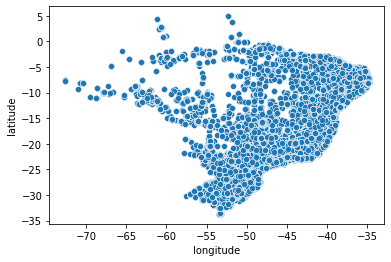

In [29]:
sns.scatterplot(x=final_df['longitude'], y=final_df['latitude'])

In [30]:
final_df

,user_id,latitude,longitude,origin,coordinates,C,M
1,0x000077FF355F239607A3327FD90C82D2,-29.925139,-51.163535,C,"-29.925139,-51.163535",1,0
2,0x000077FF355F239607A3327FD90C82D2,-29.930372,-51.162725,M,"-29.930372,-51.162725",0,1
3,0x0000A09DE7C5FBBB72EE84E5A44E6E5C,-25.214658,-49.347787,M,"-25.214658,-49.347787",0,1
4,0x0000A09DE7C5FBBB72EE84E5A44E6E5C,-25.434135,-49.265799,C,"-25.434135,-49.265799",1,0
5,0x00018E5BD60A17CD41BB547D0034496C,2.773165,-60.724444,C,"2.773165,-60.724444",1,0
...,...,...,...,...,...,...,...
313442,0xFFFF595F516EF7024A74D8594B7CC72E,-19.918043,-43.945335,M,"-19.918043,-43.945335",0,1
313443,0xFFFFA4BFD55F033F1AE42997539F51D1,-23.079803,-47.206807,C,"-23.079803,-47.206808",1,0
313444,0xFFFFA4BFD55F033F1AE42997539F51D1,-23.096441,-47.230640,M,"-23.096441,-47.23064",0,1
313445,0xFFFFFC97A8A9F1EDEC63F807F12F538B,-23.538271,-46.400885,M,"-23.538271,-46.400885",0,1


## 3. Training and fitting

Now that we have our final dataframe with 309.388 rows, we need to feed it to our model. 

### Grouping by 'user_id'


After some analysis, we decided that the best way to do that was to give the model only one coordinate per user, taking the mean of all the locations of that user:

In [31]:
mean_user = final_df.groupby('user_id', as_index=False).agg({'latitude': np.mean, 'longitude': np.mean})

# showing the first 5 results:
mean_user.head(5)

,user_id,latitude,longitude
0,0x000077FF355F239607A3327FD90C82D2,-29.927755,-51.163130
1,0x0000A09DE7C5FBBB72EE84E5A44E6E5C,-25.324396,-49.306793
2,0x00018E5BD60A17CD41BB547D0034496C,2.784756,-60.721383
3,0x0005014F8A548CDD4A201853D3BE74EB,-22.868730,-43.240398
4,0x00052935A7B810E27826BB3406780761,-21.153670,-47.830782


### K-Means 1

Now that we have our input ready, we can feed it to the model.

The KMeans is a unsupervised machine learning model, that labels the data into any given number of clusters. It's the best model to use when dealing with coordinates:

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

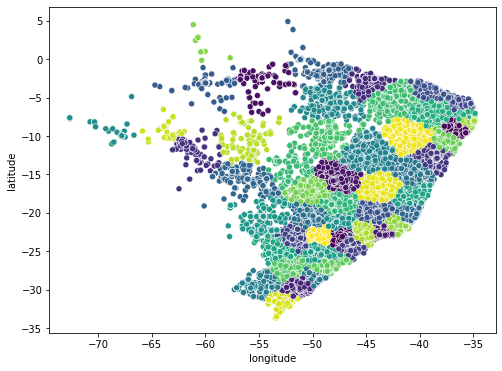

In [32]:
# keeping only the necessary features for the model:
X = mean_user[['latitude', 'longitude']]

# we instantiante the KMeans with 50 clusters and fit our X in it:
km50 = KMeans(n_clusters=50, random_state=1)
km50.fit(X)

# plotting the original dataframe sectioned with the 50 clusters represented by a different colour:
plt.figure(figsize=(8,6))
sns.scatterplot(x=X['longitude'], y=X['latitude'], c=km50.labels_)

The map above shows us the division of the 50 clusters that the model calculated. It's clear that the northwestern users are more dispersed while the southeastern users are more numbered and closely gathered. 


Now that we have the clusters, we need to analyze the number of users of each:

In [33]:
# first we transform the model's centroids in a dataframe, rename the columns and create a coordinates column:

centroids = pd.DataFrame(km50.cluster_centers_)
centroids.columns = ['centroid_latitude', 'centroid_longitude']
centroids['coordinates'] = round(centroids['centroid_latitude'], 6).astype(str) + ',' + round(centroids['centroid_longitude'], 6).astype(str)

# then we transform the model's labels (number of each cluster) in a dataframe:

clusters = pd.DataFrame(pd.DataFrame(km50.labels_).value_counts().sort_index())
clusters.columns = ['nb_of_users']
clusters.reset_index(drop=True, inplace=True)


# at last we merge them to get a dataframe with all important info on the clusters, and sort it by number of users:

clusters = clusters.merge(centroids, left_index=True, right_index=True)
clusters['label'] = clusters.index
clusters.sort_values('nb_of_users', ascending=False).head(10)

,nb_of_users,centroid_latitude,centroid_longitude,coordinates,label
9,26099,-23.592930,-46.607312,"-23.59293,-46.607312",9
4,10977,-22.754726,-43.335717,"-22.754726,-43.335717",4
13,6045,-19.948321,-43.983896,"-19.948321,-43.983896",13
0,5359,-22.990579,-47.287872,"-22.990579,-47.287872",0
5,5174,-29.779276,-51.199205,"-29.779276,-51.199205",5
27,4421,-25.438952,-49.289371,"-25.438952,-49.289371",27
37,4307,-27.018249,-48.771698,"-27.018249,-48.771698",37
8,4052,-12.754281,-38.606806,"-12.754281,-38.606806",8
42,4029,-8.087716,-35.071499,"-8.087716,-35.071499",42
3,3463,-15.836250,-47.983347,"-15.83625,-47.983347",3


The results listed above shows that the top 1 cluster has 26.099 users and it's based in the city of São Paulo. From this point forward, we can focus on any of this clusters. As an example, we'll focus on the 1st cluster from now on.

### K-Means 2.1

Now that we have only the values of a single cluster, we can apply again the K-Means model to split all data into smaller clusters. Since the target is to build an arena for 1500 players, we're gonna use a variation of the model called K-Means Constrained, that is similar to the regular K-Means but also allows you to restrict the max and min number of elements per cluster.


But first, we're gonna filter the entire dataset to select only the users labeled to the top 1 cluster:

In [34]:
# we can go back to our model input and apply the designated label for each user:

km50_results = mean_user.merge(pd.DataFrame(km50.labels_), left_index=True, right_index=True)
km50_results.rename(columns={0: 'label'}, inplace=True)

# focusing on the 1st cluster, we'll attribute all rows with the 1st label to a new variable called 'sp':
sp = km50_results[km50_results['label'] == clusters.sort_values('nb_of_users', ascending=False)['label'].values[0]]
sp

,user_id,latitude,longitude,label
6,0x0006B527DD261EBBBC2222CFC7F42381,-23.522237,-46.856618,9
11,0x0007F9CC1C5D3E9FA36E0E4A6E12F80C,-23.602084,-46.693084,9
14,0x000AA768B732B483C4B63AAEB4089B4D,-23.497683,-46.613610,9
24,0x000F1FDD7CD3D4E9C501087FFE30B60E,-23.626863,-46.598445,9
28,0x001067BFB9BD0A1AAF71F410B2B2C39F,-23.545778,-46.444077,9
...,...,...,...,...
124172,0xFFEFD23ED5398D9AFF039F832FD030CE,-23.573478,-46.427033,9
124177,0xFFF3EA6A995FE822B2149B6A604C2808,-23.447789,-46.380845,9
124178,0xFFF434506FF338CC8D04936DA1613A56,-23.553122,-46.601391,9
124185,0xFFF72DFCF169AB7387FE7DD75250C422,-23.753299,-46.789680,9


In [35]:
# we need to discard the 'label' column because we're gonna create a new 'label' in the future:
sp = sp.drop(columns=['label'])
sp.reset_index(drop=True, inplace=True)

Now we have a smaller dataframe containing only the 26.099 users that the model classified for the label 9.

In [36]:
%%time

# Keeping only the necessary columns for the model:
X_sp = sp[['latitude', 'longitude']]

# Parameters of the model
size_max_model = 4000
size_min_model = 500
max_iter_model = 100

# Number of clusters (total real players divided by estimate players per arena 241 clusters)
n_clusters_model = int(round((len(sp) / 1000),0) +1)
n_clusters_model

# Fiting the data to the model:
kmsp = KMeansConstrained(#n_clusters=n_clusters_model,
                         size_min=size_min_model,
                         #size_max=size_max_model,
                         max_iter=max_iter_model,
                         random_state=1)
kmsp.fit(X_sp)

CPU times: user 6min 46s, sys: 3min 27s, total: 10min 14s
Wall time: 3min


KMeansConstrained(copy_x=True, init='k-means++', max_iter=100, n_clusters=8,
         n_init=10, n_jobs=1, random_state=1, size_max=None, size_min=500,
         tol=0.0001, verbose=False)

We've trained our model with the São Paulo's dataframe, limiting the size of elements per cluster to 500 minimum and 1500 maximum. The result was a division of this particular cluster (São Paulo) into 27 sub-clusters.

Now, we'll build a dataframe with important info of each sub-cluster, so we can analyze and decide the best spot to build the arena:

In [37]:
# as before, we'll add the sub-cluster's info on the previous dataframe:
centroids_sp = pd.DataFrame(kmsp.cluster_centers_)
centroids_sp.columns = ['centroid_latitude', 'centroid_longitude']
centroids_sp['centroid_coordinates'] = round(centroids_sp['centroid_latitude'], 6).astype(str) + ',' + round(centroids_sp['centroid_longitude'], 6).astype(str)

clusters_sp = pd.DataFrame(pd.DataFrame(kmsp.labels_).value_counts().sort_index())
clusters_sp.columns = ['nb_of_users']
clusters_sp.reset_index(drop=True, inplace=True)

results_sp = pd.merge(centroids_sp, clusters_sp, left_index=True, right_index=True)
results_sp['#_centroids'] = results_sp.index

# showing some of the results:
results_sp.head(5)

,centroid_latitude,centroid_longitude,centroid_coordinates,nb_of_users,#_centroids
0,-23.577351,-46.815903,"-23.577351,-46.815903",4944,0
1,-23.457642,-46.105432,"-23.457642,-46.105432",678,1
2,-23.664875,-46.619187,"-23.664875,-46.619187",5352,2
3,-23.527485,-46.461568,"-23.527485,-46.461568",6161,3
4,-23.967416,-46.344422,"-23.967416,-46.344422",1746,4


Now we have a dataframe with all sub-clusters centroid's coordinates, number of users and designated label.


We plotted all 27 centroid's coordinates in the map bellow:

ADD HERE MAP OF SÃO PAULO'S CENTROIDS

As you can see, there is a bigger density of sub-clusters around the city of São Paulo, but also some distant ones.

## 4. New features for analysis

Now that we have this sub-clusters to check, we're gonna add some important features to improve the analysis and aid the business decision.

### Distance

Now we're gonna build a new feature that calculates the distance between every user and it's designated centroid. In order to do that we'll use a navigation formula called 'haversine', that takes coordinates and returns the distance in km:

In [38]:
# Merging grouped_users with the designates labels and creating a new column for future use:
distance_sp = sp.merge(pd.DataFrame(kmsp.labels_), left_index=True, right_index=True)
distance_sp
distance_sp.rename(columns={0: 'label'}, inplace=True)
distance_sp['centroid_coord'] = None

# Adding centroids' coordinates to each user, so we can calculate the distance:
for row in range(len(results_sp)):
    distance_sp.loc[distance_sp['label'] == results_sp['#_centroids'][row], 
                    'centroid_coord' ] = results_sp['centroid_coordinates'][row]

# splitting the centroids' coordinates into two new columns 'centroid_lat' and 'centroid_long':
distance_sp['centroid_lat'] = distance_sp['centroid_coord'].apply(lambda x: x.split(',')[0]).astype(float)
distance_sp['centroid_long'] = distance_sp['centroid_coord'].apply(lambda x: x.split(',')[1]).astype(float)

# Rename to better identify differents lat and lon
distance_sp.rename(columns={'latitude': 'user_lat',
                            'longitude': 'user_long'},
                              inplace=True)

# creating an empty column and applying the 'haversine' method (imported from 'haversine module') to each row:
distance_sp['distance_km'] = 0.0
for row in distance_sp.index:
    distance_sp['distance_km'][row] = round(haversine([distance_sp['user_lat'][row], 
                                                      distance_sp['user_long'][row]],
                                                      [distance_sp['centroid_lat'][row], 
                                                      distance_sp['centroid_long'][row]]
                                                     ), 2)
distance_sp.head(10)

/tmp/ipykernel_1484/122380002.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distance_sp['distance_km'][row] = round(haversine([distance_sp['user_lat'][row],


,user_id,user_lat,user_long,label,centroid_coord,centroid_lat,centroid_long,distance_km
0,0x0006B527DD261EBBBC2222CFC7F42381,-23.522237,-46.856618,0,"-23.577351,-46.815903",-23.577351,-46.815903,7.40
1,0x0007F9CC1C5D3E9FA36E0E4A6E12F80C,-23.602084,-46.693084,7,"-23.519164,-46.667171",-23.519164,-46.667171,9.59
2,0x000AA768B732B483C4B63AAEB4089B4D,-23.497683,-46.613610,7,"-23.519164,-46.667171",-23.519164,-46.667171,5.96
3,0x000F1FDD7CD3D4E9C501087FFE30B60E,-23.626863,-46.598445,2,"-23.664875,-46.619187",-23.664875,-46.619187,4.73
4,0x001067BFB9BD0A1AAF71F410B2B2C39F,-23.545778,-46.444077,3,"-23.527485,-46.461568",-23.527485,-46.461568,2.70
5,0x00110DB5B332B4B5F7B6C6A62BA5CF09,-23.613508,-46.784491,0,"-23.577351,-46.815903",-23.577351,-46.815903,5.14
6,0x00120296C2B03D1B232CE8FE54E61642,-23.575472,-46.801437,0,"-23.577351,-46.815903",-23.577351,-46.815903,1.49
7,0x0012F7C74A1C743CCA0468C3F97F2207,-23.971426,-46.274487,4,"-23.967416,-46.344422",-23.967416,-46.344422,7.12
8,0x00181B740357B70C0C3EAF76133192ED,-23.529814,-46.472259,3,"-23.527485,-46.461568",-23.527485,-46.461568,1.12
9,0x0019348117245803450CBB299683F4E1,-23.517928,-46.714270,7,"-23.519164,-46.667171",-23.519164,-46.667171,4.80


This 'distance_sp' dataframe allows us to take the mean distance between users and centroids per sub-cluster, so we can have a general idea about each sub-cluster that the model returned:

In [39]:
# Calculating the mean and max distance within each cluster:
mean_dist_label = distance_sp.groupby('label').agg({'distance_km': [np.mean, np.max]})

# Showing the top 10 result ordered by mean distance:
mean_dist_label.sort_values(('distance_km', 'mean')).head(10)

distance_km        
             mean    amax
label                    
7        6.621262   22.29
2        7.880340   24.38
4        9.053872  181.12
3        9.054701   27.02
0        9.461430   36.20
1       18.880147   75.63
5       19.094219   62.33
6       51.818560  225.49

Now we'll merge this sub-cluster's info with the 'results_sp' dataframe and add new distance's features to it:

In [40]:
# merging the results:
final_sp = results_sp.merge(round(mean_dist_label, 2), left_index=True, right_index=True )
final_sp.rename(columns={final_sp.columns[-2]: 'mean_distance', final_sp.columns[-1]: 'max_distance'}, inplace=True)

# creating new columns that shows the 3rd quartile for each cluster:
for i in range(len(final_sp)):
    final_sp.loc[i,'25%'] = round(distance_sp[distance_sp['label'] == i]['distance_km'].describe().loc['25%'], 2)
    final_sp.loc[i,'75%'] = round(distance_sp[distance_sp['label'] == i]['distance_km'].describe().loc['75%'], 2)
final_sp.sort_values('75%', inplace=True)
final_sp.reset_index(drop=True, inplace=True)
final_sp.head(10)

/home/franciscodidier/.pyenv/versions/3.8.6/envs/Appito_Arenas/lib/python3.8/site-packages/pandas/core/frame.py:9186: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  return merge(


,centroid_latitude,centroid_longitude,centroid_coordinates,nb_of_users,#_centroids,mean_distance,max_distance,25%,75%
0,-23.519164,-46.667171,"-23.519164,-46.667171",5943,7,6.62,22.29,4.36,8.42
1,-23.664875,-46.619187,"-23.664875,-46.619187",5352,2,7.88,24.38,5.37,10.07
2,-23.577351,-46.815903,"-23.577351,-46.815903",4944,0,9.46,36.20,6.09,11.13
3,-23.527485,-46.461568,"-23.527485,-46.461568",6161,3,9.05,27.02,5.77,11.53
4,-23.967416,-46.344422,"-23.967416,-46.344422",1746,4,9.05,181.12,3.22,11.55
5,-23.457642,-46.105432,"-23.457642,-46.105432",678,1,18.88,75.63,11.99,22.23
6,-23.178858,-46.679304,"-23.178858,-46.679304",775,5,19.09,62.33,13.17,22.57
7,-24.181372,-47.013034,"-24.181372,-47.013034",500,6,51.82,225.49,31.73,61.50


### Distribution

Now we have a dataframe presenting all sub-clusters and important features of each one. The first sub-cluster of the table above has 1500 users, with a mean distance between users and centroid of 2.76 km, and the most distant user is 5.12 km far from the centroid. Also, 75% of all users of this sub-cluster are inside a radius of 3.59 km.


It's interesting to plot the distribution of any sub-cluster's users in blue, with it's centroid highlighted in red. In the next cell we do that with the top 4 sub-clusters:

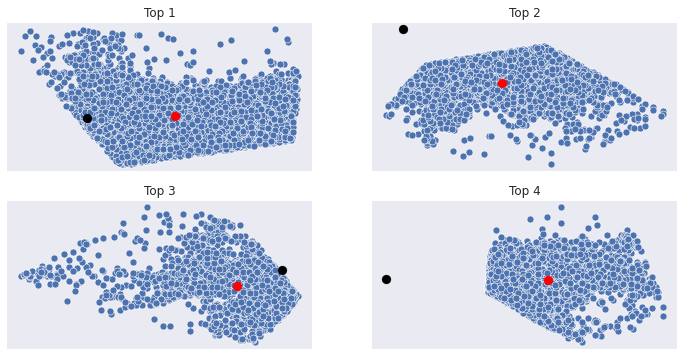

In [41]:
plt.figure(figsize=(12, 6))
plt.style.use('seaborn')

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.title(f'Top {i+1}')
    sns.scatterplot(x=distance_sp[distance_sp['label'] == final_sp['#_centroids'][i]]['user_long'],
                    y=distance_sp[distance_sp['label'] == final_sp['#_centroids'][i]]['user_lat'])
    plt.scatter(x=final_sp['centroid_longitude'][i], y=final_sp['centroid_latitude'][i], color='r', s=80),
    plt.scatter(x=-46.743107712605976, y=-23.524052597676175, color='black', s=80)
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks([])
    plt.yticks([])

From the graph above we can see that all top 4 sub-clusters have steady distribution around it's centroids.

### Geographic features


Now we'll add geographical info to the final dataframe by using 'geopy' module once more. This python package accepts coordinates as inputs and returns all the hole address of it.

In [42]:
# Instantiating a Geopy method to a 'geolocator' variable:
geolocator = Nominatim(user_agent="myGeocoder")

# Extracting from geopy the location details for each sub-cluster calculated above to a new dataframe 'location_all_forloop':
keys = ['suburb', 'town', 'city', 'state']
list_loc = []

for l in range(len(final_sp['centroid_coordinates'])):
    try:
        location = geolocator.reverse(final_sp['centroid_coordinates'][l])
        dict_location = location.raw['address']
    except:
        dict_location = dict(keys = ['suburb', 'town', 'city', 'state'])
    for key in keys:
        dict_location = { key: dict_location.get(key) for key in keys }
    list_loc.append(dict_location)

# Create a new column copying the content of 'centroid_coordinates' in 'final_sp':
location_all_forloop = pd.DataFrame(list_loc)
location_all_forloop['centroid_coordinates'] = final_sp['centroid_coordinates']

# Merging the new dataframe with geo info to a copy of 'final_df', so we can maintain the previous results intact:
geo_clusters = final_sp.merge(location_all_forloop, on='centroid_coordinates')

# For Geopy some coordinates may have a 'town' instead of a 'city', so we're merging everything into a 'city' column:
for row in range(len(geo_clusters['city'])):
    if geo_clusters['city'][row] == None:
        geo_clusters['city'][row] = geo_clusters['town'][row]

geo_clusters.drop(columns=['centroid_latitude', 'centroid_longitude', 'town'], inplace=True)
geo_clusters.head(10)

/tmp/ipykernel_1484/3324254766.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_clusters['city'][row] = geo_clusters['town'][row]


,centroid_coordinates,nb_of_users,#_centroids,mean_distance,max_distance,25%,75%,suburb,city,state
0,"-23.519164,-46.667171",5943,7,6.62,22.29,4.36,8.42,Barra Funda,São Paulo,São Paulo
1,"-23.664875,-46.619187",5352,2,7.88,24.38,5.37,10.07,Taboão,Diadema,São Paulo
2,"-23.577351,-46.815903",4944,0,9.46,36.20,6.09,11.13,Jardim Santa Maria,Osasco,São Paulo
3,"-23.527485,-46.461568",6161,3,9.05,27.02,5.77,11.53,Vila Guarani,São Paulo,São Paulo
4,"-23.967416,-46.344422",1746,4,9.05,181.12,3.22,11.55,Pompéia,Santos,São Paulo
5,"-23.457642,-46.105432",678,1,18.88,75.63,11.99,22.23,None,Mogi das Cruzes,São Paulo
6,"-23.178858,-46.679304",775,5,19.09,62.33,13.17,22.57,None,Jarinu,São Paulo
7,"-24.181372,-47.013034",500,6,51.82,225.49,31.73,61.50,Bambú,Peruíbe,São Paulo


### Economic feature

We're also gonna add the 'GDP per capita' of each city to help evaluate the centroids and aid the decision about the place.
We'll do this by importing a done table with this information for every city in Brazil and merging with our dataframe:

In [43]:
gdp_pc = pd.read_csv('gs://appito_arenas_data/gdp_percapita_UF.csv')
gdp_pc.head(10)

,city,UF,gdp_pc_R$
0,Tremedal,BA,3140.24
1,Turuçu,RS,11430.97
2,Vitória,ES,61790.59
3,Jacutinga,MG,11567.21
4,Nazária,PI,2653.75
5,Pedra Azul,MG,7212.45
6,Teresina,PI,10841.20
7,Amarante,PI,3650.95
8,Matrinchã,GO,10387.00
9,Cachoeirinha,PE,4438.22


In [44]:
# Adding gdp per capita to geo_clusters:
geo_clusters = geo_clusters.merge(gdp_pc[gdp_pc['UF'] == 'SP'], on='city', how='left')
geo_clusters

,centroid_coordinates,nb_of_users,#_centroids,mean_distance,max_distance,25%,75%,suburb,city,state,UF,gdp_pc_R$
0,"-23.519164,-46.667171",5943,7,6.62,22.29,4.36,8.42,Barra Funda,São Paulo,São Paulo,SP,35271.93
1,"-23.664875,-46.619187",5352,2,7.88,24.38,5.37,10.07,Taboão,Diadema,São Paulo,SP,25066.30
2,"-23.577351,-46.815903",4944,0,9.46,36.20,6.09,11.13,Jardim Santa Maria,Osasco,São Paulo,SP,43994.47
3,"-23.527485,-46.461568",6161,3,9.05,27.02,5.77,11.53,Vila Guarani,São Paulo,São Paulo,SP,35271.93
4,"-23.967416,-46.344422",1746,4,9.05,181.12,3.22,11.55,Pompéia,Santos,São Paulo,SP,54054.76
5,"-23.457642,-46.105432",678,1,18.88,75.63,11.99,22.23,None,Mogi das Cruzes,São Paulo,SP,20552.18
6,"-23.178858,-46.679304",775,5,19.09,62.33,13.17,22.57,None,Jarinu,São Paulo,SP,17486.51
7,"-24.181372,-47.013034",500,6,51.82,225.49,31.73,61.50,Bambú,Peruíbe,São Paulo,SP,10653.18


Now we have a dataframe with all 27 optimal coordinates that our model returned, in addition to some important info on each one of them: number of users, mean and max distance (user x centroid), 3rd quartile, location info (suburb, city, state) and also the GDP per capita of the city. We believe this is enough to make a smart business decision about building the arena.

## Extra 1: Zap Imóveis scrapping


As an extra content, our project also offers real estate information. Once you've chosen the best potential(s) spots based on our model's output, we'll show you all empty lands available in that suburb registered on 'Zap Imóveis', one of the top real estate websites in Brazil.


For instance, we choose the 2nd cluster's suburb:

In [45]:
suburb = 'Pompéia'

In [46]:
geo_clusters['param_scrapping'] = (geo_clusters['UF'] +'+'+ geo_clusters["city"].replace(' ','-',regex=True)\
                                  +'++'+geo_clusters["suburb"].replace(' ','-',regex=True)).str.normalize('NFKD')\
                                  .str.encode('ascii', errors='ignore')\
                                  .str.decode('utf-8').str.lower()

sub_index = geo_clusters[geo_clusters['suburb'] == suburb]['param_scrapping'].index[0]

scrapping_info = []
tipo = "terrenos-lotes-comerciais" #galpao-deposito-armazem
pages = 10
acao = 'aluguel'# venda

try:
    param_scrapping = geo_clusters["param_scrapping"][sub_index].replace('vila', 'vl')
    df_forloop = zap.search(localization=param_scrapping, num_pages=pages, tipo=tipo, dictionary_out=True, acao=acao)
    df_forloop = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in df_forloop.items() ]))
    df_forloop['city'] = geo_clusters["city"][sub_index]
    df_forloop['state'] = geo_clusters["state"][sub_index]
    df_forloop['suburb'] = geo_clusters["suburb"][sub_index]
    scrapping_info.append(df_forloop)
    scrapping_info = pd.concat(scrapping_info)
except:
    print('Sorry! There are currently zero options available for this suburb in Zap Imóveis')
    pass
scrapping_info

,price,bedrooms,bathrooms,vacancies,total_area_m2,address,description,link,city,state,suburb
0,14500,0,0,0,672,Pompeia,Lote/Terreno para aluguel e venda - 672 metros...,/imovel/aluguel-terreno-lote-comercial-pompeia...,Santos,São Paulo,Pompéia


The output was 8 available empty lands for rent in the suburb of 'Vila Carrão', in the city of São Paulo, in addition to the price, area in m2, address, description and the link of the place at Zap Imóveis website.

## Extra 2: K-Means 2.2

What about the results for other clusters? In the next cell we run the results for the top 2 cluster, based on the city of Rio de Janeiro:

<timed exec>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/franciscodidier/.pyenv/versions/3.8.6/envs/Appito_Arenas/lib/python3.8/site-packages/pandas/core/frame.py:9186: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  return merge(


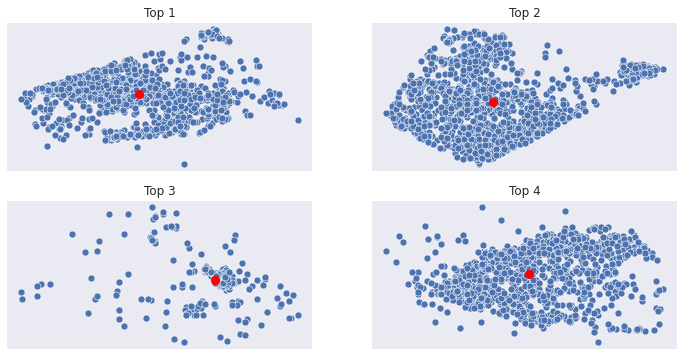

<timed exec>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: user 2min 22s, sys: 1min 23s, total: 3min 45s
Wall time: 1min 1s


,centroid_coordinates,nb_of_users,#_centroids,mean_distance,max_distance,25%,75%,suburb,city,state,UF,gdp_pc_R$
0,"-22.914238,-43.23248",1486,1,4.67,13.90,2.60,6.14,Maracanã,Rio de Janeiro,Rio de Janeiro,RJ,28405.95
1,"-22.838939,-43.299496",1493,5,5.22,12.73,3.38,6.51,Penha Circular,Rio de Janeiro,Rio de Janeiro,RJ,28405.95
2,"-21.753683,-43.397712",626,2,10.82,79.85,4.33,7.49,Recanto dos Bruggers,Juiz de Fora,Minas Gerais,NaN,NaN
3,"-22.866507,-43.05649",1310,10,5.95,14.40,4.27,7.50,Novo México,São Gonçalo,Rio de Janeiro,RJ,9699.16
4,"-22.79052,-43.419869",1478,0,5.85,13.22,3.81,7.71,Cosmorama,Mesquita,Rio de Janeiro,RJ,7928.46
5,"-22.938768,-43.386215",1203,3,6.36,15.04,4.32,8.06,Jacarepaguá,Rio de Janeiro,Rio de Janeiro,RJ,28405.95
6,"-22.91849,-43.607608",846,9,7.56,52.89,4.06,9.09,Cosmos,Rio de Janeiro,Rio de Janeiro,RJ,28405.95
7,"-22.678496,-43.253132",500,6,8.28,18.71,5.52,10.54,Saracuruna,Duque de Caxias,Rio de Janeiro,RJ,29501.24
8,"-22.434576,-43.094435",500,11,17.11,45.67,12.17,18.52,None,Petrópolis,Rio de Janeiro,RJ,18504.77
9,"-22.805855,-42.748842",500,7,20.32,45.26,13.92,22.87,Muriqui,Itaboraí,Rio de Janeiro,RJ,8792.05


In [47]:
%%time

rj = km50_results[km50_results['label'] == clusters.sort_values('nb_of_users', ascending=False)['label'].values[1]]
rj = rj.drop(columns=['label'])
rj.reset_index(drop=True, inplace=True)
X_rj = rj[['latitude', 'longitude']]
size_max_model = 1500
size_min_model = 500
max_iter_model = 50
n_clusters_model = int(round((len(rj) / 1000),0) +1)
n_clusters_model
kmrj = KMeansConstrained(n_clusters=n_clusters_model, size_min=size_min_model,
                         size_max=size_max_model, max_iter=max_iter_model, random_state=1)
kmrj.fit(X_rj)
centroids_rj = pd.DataFrame(kmrj.cluster_centers_)
centroids_rj.columns = ['centroid_latitude', 'centroid_longitude']
centroids_rj['centroid_coordinates'] = round(centroids_rj['centroid_latitude'], 6).astype(str) + ',' + round(centroids_rj['centroid_longitude'], 6).astype(str)
clusters_rj = pd.DataFrame(pd.DataFrame(kmrj.labels_).value_counts().sort_index())
clusters_rj.columns = ['nb_of_users']
clusters_rj.reset_index(drop=True, inplace=True)
results_rj = pd.merge(centroids_rj, clusters_rj, left_index=True, right_index=True)
results_rj['#_centroids'] = results_rj.index
results_rj.head(5)
distance_rj = rj.merge(pd.DataFrame(kmrj.labels_), left_index=True, right_index=True)
distance_rj
distance_rj.rename(columns={0: 'label'}, inplace=True)
distance_rj['centroid_coord'] = None
for row in range(len(results_rj)):
    distance_rj.loc[distance_rj['label'] == results_rj['#_centroids'][row], 
                    'centroid_coord' ] = results_rj['centroid_coordinates'][row]
distance_rj['centroid_lat'] = distance_rj['centroid_coord'].apply(lambda x: x.split(',')[0]).astype(float)
distance_rj['centroid_long'] = distance_rj['centroid_coord'].apply(lambda x: x.split(',')[1]).astype(float)
distance_rj.rename(columns={'latitude': 'user_lat',
                            'longitude': 'user_long'},
                              inplace=True)
distance_rj['distance_km'] = 0.0
for row in distance_rj.index:
    distance_rj['distance_km'][row] = round(haversine([distance_rj['user_lat'][row], 
                                                      distance_rj['user_long'][row]],
                                                      [distance_rj['centroid_lat'][row], 
                                                      distance_rj['centroid_long'][row]]
                                                     ), 2)
mean_dist_label = distance_rj.groupby('label').agg({'distance_km': [np.mean, np.max]})
mean_dist_label.sort_values(('distance_km', 'mean')).head(10)
final_rj = results_rj.merge(round(mean_dist_label, 2), left_index=True, right_index=True )
final_rj.rename(columns={final_rj.columns[-2]: 'mean_distance', final_rj.columns[-1]: 'max_distance'}, inplace=True)
for i in range(len(final_rj)):
    final_rj.loc[i,'25%'] = round(distance_rj[distance_rj['label'] == i]['distance_km'].describe().loc['25%'], 2)
    final_rj.loc[i,'75%'] = round(distance_rj[distance_rj['label'] == i]['distance_km'].describe().loc['75%'], 2)
final_rj.sort_values('75%', inplace=True)
final_rj.reset_index(drop=True, inplace=True)
plt.figure(figsize=(12, 6))
plt.style.use('seaborn')
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.title(f'Top {i+1}')
    sns.scatterplot(x=distance_rj[distance_rj['label'] == final_rj['#_centroids'][i]]['user_long'],
                    y=distance_rj[distance_rj['label'] == final_rj['#_centroids'][i]]['user_lat'])
    plt.scatter(x=final_rj['centroid_longitude'][i], y=final_rj['centroid_latitude'][i], color='r', s=80),
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks([])
    plt.yticks([])
plt.show();
geolocator = Nominatim(user_agent="myGeocoder")
keys = ['suburb', 'town', 'city', 'state']
list_loc = []
for l in range(len(final_rj['centroid_coordinates'])):
    try:
        location = geolocator.reverse(final_rj['centroid_coordinates'][l])
        dict_location = location.raw['address']
    except:
        dict_location = dict(keys = ['suburb', 'town', 'city', 'state'])
    for key in keys:
        dict_location = { key: dict_location.get(key) for key in keys }
    list_loc.append(dict_location)
location_all_forloop = pd.DataFrame(list_loc)
location_all_forloop['centroid_coordinates'] = final_rj['centroid_coordinates']
geo_clusters_rj = final_rj.merge(location_all_forloop, on='centroid_coordinates')
for row in range(len(geo_clusters_rj['city'])):
    if geo_clusters_rj['city'][row] == None:
        geo_clusters_rj['city'][row] = geo_clusters_rj['town'][row]
geo_clusters_rj.drop(columns=['centroid_latitude', 'centroid_longitude', 'town'], inplace=True)
gdp_pc = pd.read_csv('gs://appito_arenas_data/gdp_percapita_UF.csv')
geo_clusters_rj = geo_clusters_rj.merge(gdp_pc[gdp_pc['UF'] == 'RJ'], on='city', how='left')
geo_clusters_rj

In [48]:
suburb = 'Jacarepaguá'

In [49]:
geo_clusters_rj['param_scrapping'] = (geo_clusters_rj['UF'] +'+'+ geo_clusters_rj["city"].replace(' ','-',regex=True)\
                                  +'++'+geo_clusters_rj["suburb"].replace(' ','-',regex=True)).str.normalize('NFKD')\
                                  .str.encode('ascii', errors='ignore')\
                                  .str.decode('utf-8').str.lower()

sub_index = geo_clusters_rj[geo_clusters_rj['suburb'] == suburb]['param_scrapping'].index[0]

scrapping_info = []
tipo = "terrenos-lotes-comerciais" #galpao-deposito-armazem
pages = 10
acao = 'venda' #aluguel 

try:
    param_scrapping = geo_clusters_rj["param_scrapping"][sub_index].replace('vila', 'vl')
    df_forloop = zap.search(localization=param_scrapping, num_pages=pages, tipo=tipo, dictionary_out=True, acao=acao)
    df_forloop = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in df_forloop.items() ]))
    df_forloop['city'] = geo_clusters_rj["city"][sub_index]
    df_forloop['state'] = geo_clusters_rj["state"][sub_index]
    df_forloop['suburb'] = geo_clusters_rj["suburb"][sub_index]
    scrapping_info.append(df_forloop)
    scrapping_info = pd.concat(scrapping_info)
except:
    print('Sorry! There are currently zero options available for this suburb in Zap Imóveis')
    pass
scrapping_info

,price,bedrooms,bathrooms,vacancies,total_area_m2,address,description,link,city,state,suburb
0,2800000,0,0,0,5000,"Avenida Comandante Guaranys, Jacarepaguá",TERRENO – 5.000m2 – JACAREPAGUÁ – RIO DE JANEI...,/imovel/venda-terreno-lote-comercial-jacarepag...,Rio de Janeiro,Rio de Janeiro,Jacarepaguá
1,4800000,0,0,0,6000,"Avenida Engenheiro Souza Filho, Jacarepaguá",Lote/Terreno para venda com 6000 metros quadra...,/imovel/venda-terreno-lote-comercial-jacarepag...,Rio de Janeiro,Rio de Janeiro,Jacarepaguá
2,5500000,0,0,0,5500,"Estrada de Camorim, Jacarepaguá",Lote/Terreno para venda tem 5500 metros quadra...,/imovel/venda-terreno-lote-comercial-jacarepag...,Rio de Janeiro,Rio de Janeiro,Jacarepaguá
3,1125000,0,0,0,76,"Avenida Almirante Júlio de Sá Bierrenbach, Jac...",Excelente Sala comercial próxima ao Centro Olí...,/imovel/venda-terreno-lote-comercial-jacarepag...,Rio de Janeiro,Rio de Janeiro,Jacarepaguá


## Conclusion

In this project we cleaned, analyzed and trained data from Appito, an app that organizes amateur soccer games, to help them decide the best spot to build a new Arena.

First, we received millions of raw data observations to clean. The output here was a dataframe close to 300k rows, containing only real users based on Brazil that played at least one match and shared their cellphone coordinates.

The second step was to group our datafame by 'user_id' and take the mean coordinates of each user, as a quick and valid measure of one's 'mean location', having so only one coordinate per user. This was the input used to train our machine learning model, K-Means, in order to split our dataset into a given number of clusters.  The output was a division of 50 clusters around the brazilian area. The top 10 clusters have a considerable number of users, and can be used for the next step of the project, a deeper analysis of a cluster.

The third step was to filter the final users' dataframe and select only users of a chosen cluster. Then we used them as input to another model called K-Means constrained, that allows you to limit the size of the new clusters. So the output was a division of sub-clusters, with maximum size of 1500 users each, and the centroid's coordinates for each sub-cluster. We then added some important features to help evaluate the optimal coordinates the model returned to us, like distance (km), distribution, geographical and economical info of the area.

As an extra step, our model provides real estate info of 'Zap Imóveis', one of the greatest websites on this matter, by only typing the name of the suburb to be searched for.

We believe that this project will help the app to choose the best spot to build their new Arena.